In [11]:
import os
from collections import defaultdict
import logging
logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(format='%(message)s')
import pickle

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import polyga.analysis as pga
from polyga import polygod as pg
from polyga import utils
from polyga.selection_schemes import elite
from rdkit import Chem, RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem import AllChem, DataStructs

In [2]:
def silly_fingerprint(df):                                                         
    """Morgan fingerprint with count of chars in smiles_string.                    
                                                                                   
    I wouldn't use this for actual research.                                       
                                                                                   
    Args:                                                                          
        df (pd.DataFrame):                                                         
            dataframe of polyga population                                         
                                                                                   
    Returns:                                                                       
        same dataframe with fingerprints attached                                  
    """                                                                            
    fp_dict = defaultdict(list)                                                    
    columns = df.columns                                                           
    for index, row in df.iterrows():                                               
        try:                                                                       
            smiles = row['smiles_string']                                          
            # These are used for ladder polymers, so we have to remove them        
            # or we get a parsing error                                            
            smiles = smiles.replace('e','*').replace('t','*').replace('d','*').replace('g','*')
            m = Chem.MolFromSmiles(smiles)                                         
            # Make radius 5 so we have unique fingerprints                         
            fp = AllChem.GetMorganFingerprintAsBitVect(m, 5, nBits=2048)           
            arr = np.zeros((0,), dtype=np.int8)                                    
            DataStructs.ConvertToNumpyArray(fp,arr)                                
            # Add fake fingerprint to differentiate repeats                        
            fp_dict['fp_' + 'num_str_atoms'].append(len(smiles))                   
            for i in range(len(arr)):                                              
                fp_dict['fp_' + str(i)].append(arr[i])                             
            for col in columns:                                                    
                fp_dict[col].append(row[col])                                      
        except Exception as e:                                                     
            # Skip failed fingerprinting                                           
            continue                                                               
                                                                                   
    fp_df = pd.DataFrame.from_dict(fp_dict)                                        
    keys = [key for key in fp_dict.keys()]                                         
    for key in keys:                                                               
        del fp_dict[key]                                                           
    del keys                                                                       
    del fp_dict                                                                    
                                                                                   
    fp_headers = [col for col in fp_df.columns if 'fp_' in col]                    
    return fp_df, fp_headers

In [3]:
def silly_property_prediction(df, fp_headers, models):                          
    """Predict silly properties of polymers                                     
                                                                                
    Args:                                                                       
        df (pd.DataFrame):                                                      
            dataframe of fingerprinted polymers                                 
        fp_headers (list):                                                      
            list of fingerprint headers                                         
        models (dict):                                                          
            Key is parameter name, value is the model                           
                                                                                
    Returns:                                                                    
        same dataframe with predictions attached                                
    """                                                                         
    prop_values = defaultdict(list)                                             
    for model in models:                                                        
        prop_values[model] = (                                                  
                models[model].predict(df[fp_headers].values).reshape(-1)        
                )                                                               
                                                                                
    keys = [key for key in prop_values.keys()]                                  
    for key in keys:                                                            
        df[key] = prop_values[key].copy()                                       
        del prop_values[key]                                                    
    del keys                                                                    
    del prop_values                                                             
                                                                                
    return df

In [4]:
def make_coolest_funniest_smartest_polymer(df, fp_headers):                     
    """Make the coolest fricken polymer around                                  
                                                                                
    Args:                                                                       
        df (pd.DataFrame):                                                      
            dataframe of population with properties predicted                   
                                                                                
    Returns:                                                                    
        Same dataframe with fitness function attached                           
    """                                                                         
    # Same names as returned property                                           
    properties = [                                                              
                  'Polymer_Coolness',                                           
                  'Polymer_Intelligence',                                       
                  'Polymer_Funnyness'                                           
                  ]                                                             
                                                                                
    fitness = []                                                                
    scaled_dict = {}                                                            
    for prop in properties:                                                     
        vals = np.array(df[prop].values)                                        
        vals = np.reshape(vals, (len(vals), -1))                                
        scaler = MinMaxScaler()                                                 
        scaled_vals = scaler.fit_transform(vals)                                
        scaled_dict[prop] = scaled_vals                                         
                                                                                
    for i in range(len(df)):                                                    
        fit = 0                                                                 
        for prop in properties:                                                 
            fit += 1/3 * scaled_dict[prop][i][0]                                
        fitness.append(fit)                                                     
                                                                                
    df['fitness'] = fitness                                                     
    return df

In [5]:
# Load models for property predictions                                             
model_folder = 'bin'                                                          
properties = {                                                                     
          'Polymer_Coolness': 'Polymer_Coolness_random-forest.pkl',                
          'Polymer_Intelligence': 'Polymer_Intelligence_random-forest.pkl',        
          'Polymer_Funnyness': 'Polymer_Funnyness_random-forest.pkl'               
         }                                                                         
models = {}

for prop in properties:                                                            
    model_file = open(os.path.join(model_folder, properties[prop]), 'rb')          
    models[prop] = pickle.load(model_file)                                         
    model_file.close()

In [6]:
planet = pg.PolyPlanet('Planet_Silly',                                             
        predict_function=silly_property_prediction,                    
        fingerprint_function=silly_fingerprint,                        
        models=models                                                              
        ) 

In [7]:
land = pg.PolyLand('Awesomeland', planet,                                          
        generative_function=utils.chromosome_ids_to_smiles,                        
        fitness_function=make_coolest_funniest_smartest_polymer        
        )

In [8]:
nation = pg.PolyNation('UnitedPolymersOfCool', land,                               
                       selection_scheme=elite,                   
                       partner_selection='diversity',                              
                       num_population_initial=180,                                 
                       ) 

In [9]:
for i in range(10):
    planet.advance_time() 

Age of planet Planet_Silly: 0
The polymers of UnitedPolymersOfCool took 0.5045 years to mature.
The polymers of UnitedPolymersOfCool took 0.04 years to graduate college.
The polymers of UnitedPolymersOfCool worked for 0.0048 years.
No other nations exist for the polymers of UnitedPolymersOfCool to immigrate to
Age of land Awesomeland is 0
UnitedPolymersOfCool of Awesomeland advances through time
The polymers of UnitedPolymersOfCool worked for 0.0034 years.
The polymers of UnitedPolymersOfCool married!
The nation of UnitedPolymersOfCool took 0.6832 years to finish their census!
There are 158 polymers in the nation
After 0.0404 years they had children.
Generation 0 of UnitedPolymersOfCool have all passed away
Age of planet Planet_Silly: 1
The polymers of UnitedPolymersOfCool took 0.4792 years to mature.
The polymers of UnitedPolymersOfCool took 0.0394 years to graduate college.
The polymers of UnitedPolymersOfCool worked for 0.0041 years.
No other nations exist for the polymers of United

In [12]:
def plot_average_lengths(df):
    """Plots average lengths of polymers vs generation for all settled_nations"""
    gens = max(df.generation) + 1
    x = np.linspace(0, gens, gens)
    settled_nations = np.unique(df.settled_nation.values)
    legend = []
    for settled_nation in settled_nations:
        tdf = df.loc[df['settled_nation'] == settled_nation]
        means = []
        for gen in range(gens):
            tdf_ = tdf.loc[tdf['generation'] == gen]
            mean = tdf_.num_chromosomes.mean()
            means.append(mean)
        plt.plot(x, means)
        legend.append(settled_nation)
    plt.legend(legend)
    plt.show()

In [21]:
def plot_property_averages(df):
    """Plots property averages for all settled_nations and displays them separately."""
    properties = ['Polymer_Coolness', 'Polymer_Funnyness','Polymer_Intelligence']
    goals = [200, 200, 200]
    dirs = [1, 1, 1]
    settled_nations = np.unique(df.settled_nation.values)
    for settled_nation in settled_nations:
        vals = []
        tdf = df.loc[df.settled_nation == settled_nation]
        for prop in properties:
            val = []
            for i in range(max(tdf.generation) + 1):
                tdf_ = tdf.loc[tdf['generation'] == i]
                val.append(tdf_[prop].mean())
            vals.append(val)

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[16,9])
        x = np.linspace(0, max(tdf.generation), max(tdf.generation)+1)
        x = [val + 1 for val in x]
        row = 0
        col = 0
        curr = 0
        for prop in properties:
            upper_line = [max(vals[curr])]*len(x)
            lower_line = [min(vals[curr])]*len(x)
            axes[col].plot(x, vals[curr], lw=2, c='darkred', zorder=4)
            axes[col].set_ylabel(prop)
            axes[col].set_ylim([min(min(vals[curr]), goals[curr]),
                                     max(max(vals[curr]), goals[curr])])
            axes[col].set_xlim([1,max(tdf.generation)+1])
            axes[col].set_xscale("log")
            goal_line = [goals[curr]]*len(x)
            if (dirs[curr] == 1 and max(vals[curr]) > goals[curr]):
                axes[col].fill_between(x,goal_line,upper_line,zorder=3,alpha=.5,
                                 facecolor='gray')
            elif (dirs[curr] == -1 and min(vals[curr]) < goals[curr]):
                axes[col].fill_between(x,lower_line,goal_line,zorder=3,alpha=.5,
                                 facecolor='gray')
            curr += 1
            col += 1
            if col > 3:
                col = 0
                row += 1
        fig.suptitle(settled_nation)
        plt.show()

In [14]:
def count_num_successful_pols(df):
    """Counts all polymers achieving targets"""
    properties = ['Polymer_Coolness', 'Polymer_Funnyness','Polymer_Intelligence']
    goals = [200, 200, 200]
    dirs = [1, 1, 1]
    settled_nations = np.unique(df.settled_nation.values)
    for settled_nation in settled_nations:
        tdf = df.loc[df.settled_nation == settled_nation]
        num_pols = len(tdf)
        for i in range(len(goals)):
            goal = goals[i]
            dir_ = dirs[i]
            prop = properties[i]
            if dir_ == 1:
                tdf = tdf.loc[tdf[prop] >= goal]
            else: 
                tdf = tdf.loc[tdf[prop] <= goal]
        print("{}: {} / {}".format(settled_nation, len(tdf), num_pols)) 

In [15]:
df, fp_df = pga.load_planet('Planet_Silly')

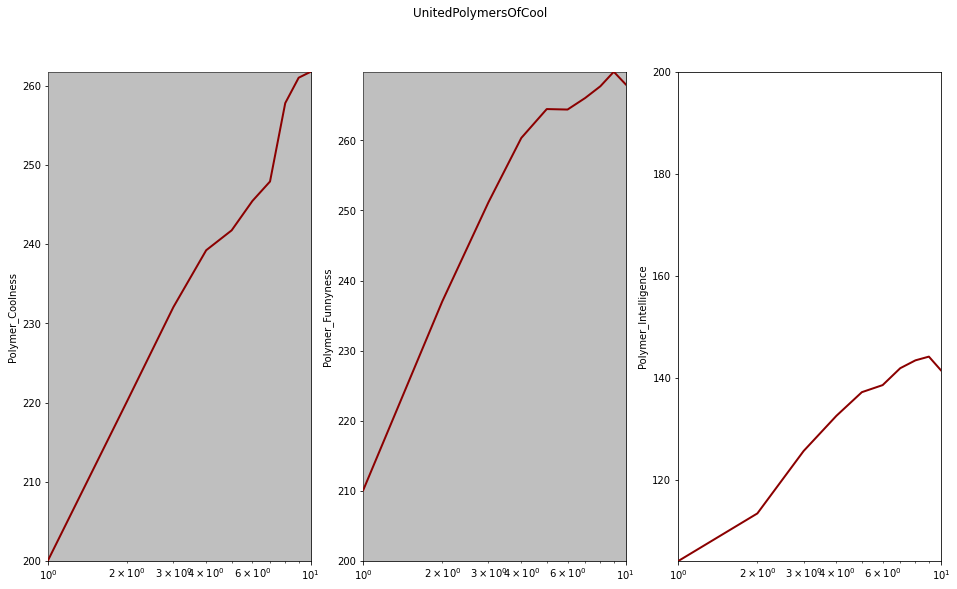

In [22]:
plot_property_averages(df)

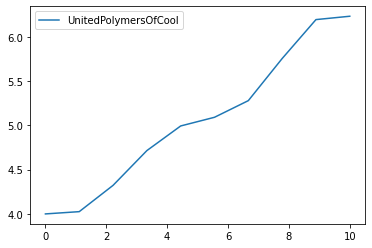

In [23]:
plot_average_lengths(df)

In [24]:
count_num_successful_pols(df)

UnitedPolymersOfCool: 0 / 1575


In [25]:
for i in range(10):
    planet.advance_time() 

Age of planet Planet_Silly: 10
The polymers of UnitedPolymersOfCool took 0.7764 years to mature.
The polymers of UnitedPolymersOfCool took 0.0397 years to graduate college.
The polymers of UnitedPolymersOfCool worked for 0.0034 years.
No other nations exist for the polymers of UnitedPolymersOfCool to immigrate to
Age of land Awesomeland is 10
UnitedPolymersOfCool of Awesomeland advances through time
The polymers of UnitedPolymersOfCool worked for 0.0036 years.
The polymers of UnitedPolymersOfCool married!
The nation of UnitedPolymersOfCool took 0.6997 years to finish their census!
There are 159 polymers in the nation
After 0.0355 years they had children.
Generation 10 of UnitedPolymersOfCool have all passed away
Age of planet Planet_Silly: 11
The polymers of UnitedPolymersOfCool took 1.05 years to mature.
The polymers of UnitedPolymersOfCool took 0.0685 years to graduate college.
The polymers of UnitedPolymersOfCool worked for 0.0054 years.
No other nations exist for the polymers of Un

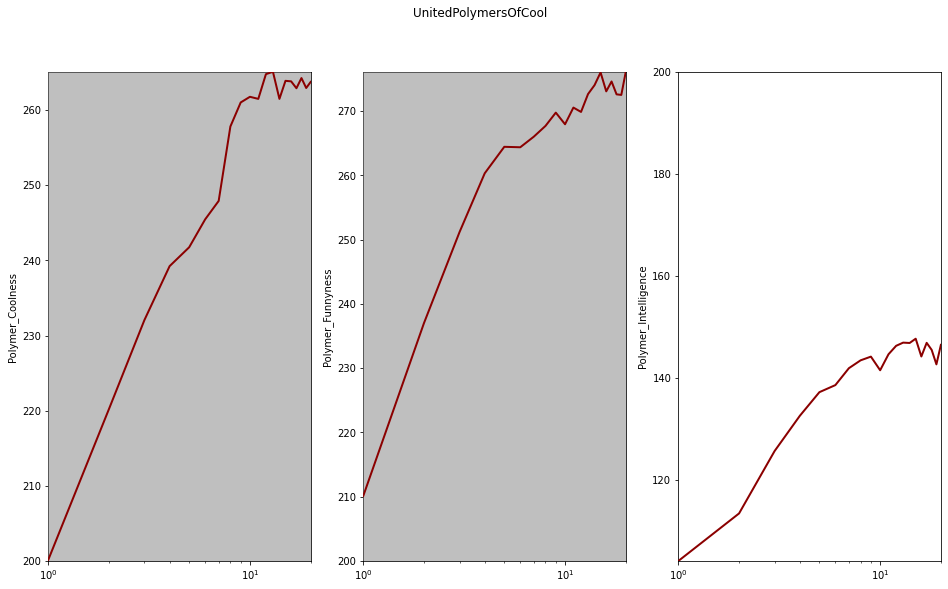

In [26]:
df, fp_df = pga.load_planet('Planet_Silly')
plot_property_averages(df)

In [27]:
def make_smartest_polymer(df, fp_headers):                     
    """Make the coolest fricken polymer around                                  
                                                                                
    Args:                                                                       
        df (pd.DataFrame):                                                      
            dataframe of population with properties predicted                   
                                                                                
    Returns:                                                                    
        Same dataframe with fitness function attached                           
    """                                                                         
    # Same names as returned property                                           
    properties = [                                                                                                       
                  'Polymer_Intelligence',                                                                                 
                  ]                                                             
                                                                                
    fitness = []                                                                
    scaled_dict = {}                                                            
    for prop in properties:                                                     
        vals = np.array(df[prop].values)                                        
        vals = np.reshape(vals, (len(vals), -1))                                
        scaler = MinMaxScaler()                                                 
        scaled_vals = scaler.fit_transform(vals)                                
        scaled_dict[prop] = scaled_vals                                         
                                                                                
    for i in range(len(df)):                                                    
        fit = 0                                                                 
        for prop in properties:                                                 
            fit += 1*scaled_dict[prop][i][0]                                
        fitness.append(fit)                                                     
                                                                                
    df['fitness'] = fitness                                                     
    return df

In [28]:
land2 = pg.PolyLand('SmartLand', planet, 
                   generative_function=utils.chromosome_ids_to_smiles,
                   fitness_function=make_smartest_polymer
)
nation2 = pg.PolyNation('Eureka', land2, selection_scheme=elite, 
                       partner_selection='diversity', num_population_initial=100,
                       emigration_rate=0.02, emigration_selection='best_worst',
)

In [29]:
for i in range(10):
    planet.advance_time() 

Age of planet Planet_Silly: 20
The polymers of UnitedPolymersOfCool took 0.8031 years to mature.
The polymers of UnitedPolymersOfCool took 0.0389 years to graduate college.
The polymers of UnitedPolymersOfCool worked for 0.0049 years.
The polymers of UnitedPolymersOfCool emigrated over 0.4535 years.
The polymers of Eureka took 0.2815 years to mature.
The polymers of Eureka took 0.0363 years to graduate college.
The polymers of Eureka worked for 0.0016 years.
The polymers of Eureka emigrated over 0.4787 years.
Age of land Awesomeland is 20
UnitedPolymersOfCool of Awesomeland advances through time
The polymers of UnitedPolymersOfCool worked for 0.0046 years.
The polymers of UnitedPolymersOfCool married!
The nation of UnitedPolymersOfCool took 0.6096 years to finish their census!
There are 141 polymers in the nation
After 0.0232 years they had children.
Generation 20 of UnitedPolymersOfCool have all passed away
Age of land SmartLand is 0
Eureka of SmartLand advances through time
The polym

The nation of UnitedPolymersOfCool took 0.6262 years to finish their census!
There are 151 polymers in the nation
After 0.0249 years they had children.
Generation 26 of UnitedPolymersOfCool have all passed away
Age of land SmartLand is 6
Eureka of SmartLand advances through time
The polymers of Eureka worked for 0.0042 years.
The polymers of Eureka married!
The nation of Eureka took 0.7189 years to finish their census!
There are 178 polymers in the nation
After 0.0249 years they had children.
Generation 6 of Eureka have all passed away
Age of planet Planet_Silly: 27
The polymers of UnitedPolymersOfCool took 0.8942 years to mature.
The polymers of UnitedPolymersOfCool took 0.04 years to graduate college.
The polymers of UnitedPolymersOfCool worked for 0.0021 years.
The polymers of UnitedPolymersOfCool emigrated over 0.4993 years.
The polymers of Eureka took 0.9082 years to mature.
The polymers of Eureka took 0.0549 years to graduate college.
The polymers of Eureka worked for 0.0046 year

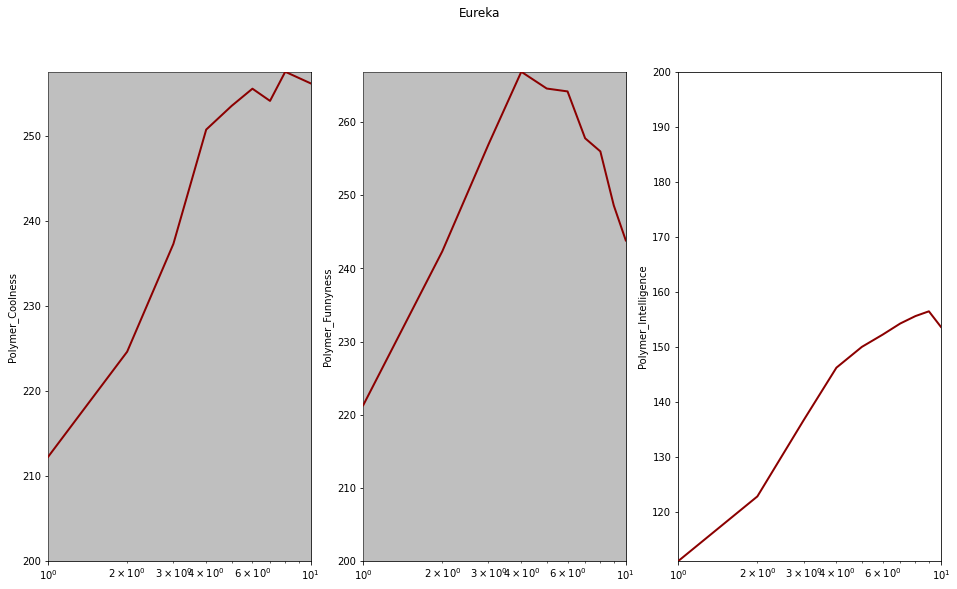

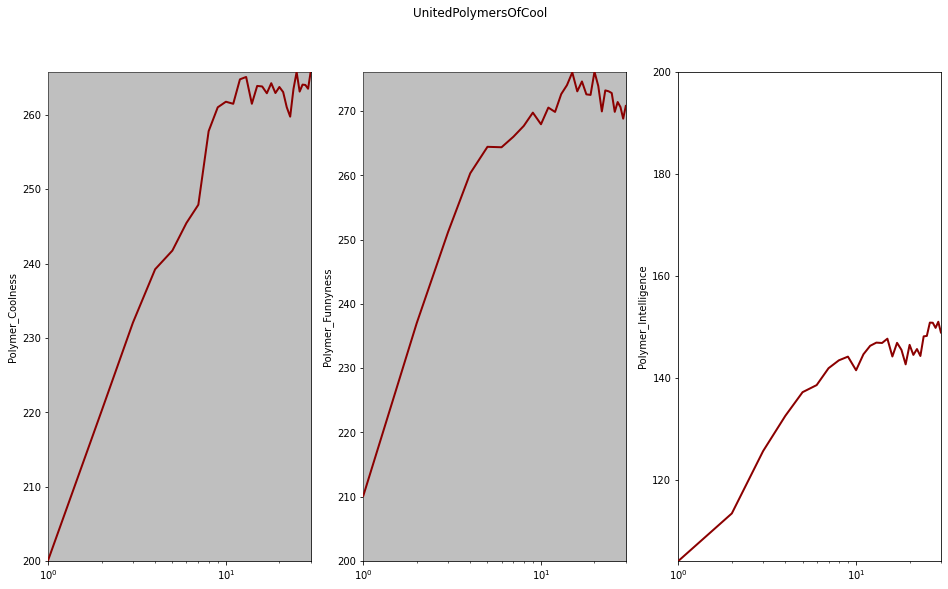

In [30]:
df, fp_df = pga.load_planet('Planet_Silly')
plot_property_averages(df)

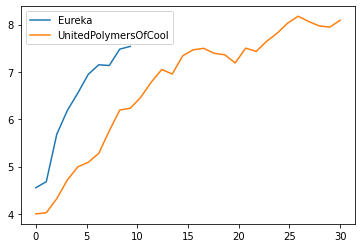

In [31]:
plot_average_lengths(df)

In [32]:
count_num_successful_pols(df)

Eureka: 0 / 1730
UnitedPolymersOfCool: 0 / 4626
